# RTL-SDR and Putting it All Together
Source and much thanks to: https://aaronscher.com/wireless_com_SDR/RTL_SDR_AM_spectrum_demod.html

In [6]:
# CPU Powered Libraries
import numpy as np
from scipy import signal

# GPU Powered Libraries
import cupy as cp
import cusignal

# RTL-SDR Support
from rtlsdr import RtlSdr

# Plotting
import matplotlib.pyplot as plt

## Reading Data from RTL-SDR

#### Read 3 seconds of signal data tuned to 88.5MHz [WAMU-DC](https://wamu.org/)

In [2]:
sdr = RtlSdr()

len_collect = 3 #seconds

# Configure Device
sdr.sample_rate = 2.4e6 #Hz
sdr.center_freq = 88.5e6 #Hz
sdr.gain = 40

# Create mapped, pinned memory for zero copy between CPU and GPU
gpu_signal = cusignal.get_shared_mem(int(len_collect * sdr.sample_rate), dtype=np.complex128)

# Read from SDR
signal = sdr.read_samples(len_collect * sdr.sample_rate)

#### Move to GPU and Plot Periodogram

In [3]:
gpu_signal[:] = signal

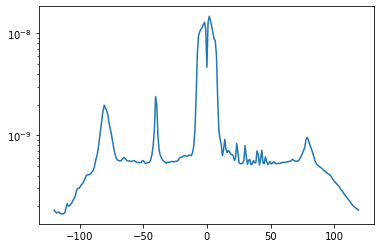

In [15]:
f, Pxx_den = cusignal.welch(gpu_signal, sdr.sample_rate, nfft=1024, scaling='density')
plt.semilogy(cp.asnumpy(cp.fft.fftshift(f/1e4)), cp.asnumpy(cp.fft.fftshift(Pxx_den)))
plt.show()

#### A Look at Timing - GPU First!

First, we'll benchmark 1 second of data

In [5]:
%%time

# Change sample rate by (3/2), e.g. 1.5 seconds of collect
up = 3
down = 2

# Read to mapped, pinned memory
gpu_signal[:] = sdr.read_samples(len_collect * sdr.sample_rate)

# Resample to 1.5 seconds - up=3, down=2
gresamp = cusignal.resample_poly(gpu_signal, up, down, window='flattop')

# Run periodogram
gf, gPxx_den = cusignal.welch(gresamp, sdr.sample_rate*(up/down), nfft=1024, scaling='density')

/home/adamt/.conda/envs/cusignal/lib/python3.7/site-packages/cusignal-0.1-py3.7.egg/cusignal/spectral.py:1272: UserWarning: Input data is complex, switching to return_onesided=False


CPU times: user 467 ms, sys: 176 ms, total: 642 ms
Wall time: 3.65 s


#### Now on to the CPU

In [17]:
%%time

# Change sample rate by (3/2), e.g. 1.5 seconds of collect
up = 3
down = 2

# Read to mapped, pinned memory
cpu_signal = sdr.read_samples(len_collect * sdr.sample_rate)

# Resample to 1.5 seconds - up=3, down=2
cresamp = signal.resample_poly(cpu_signal, up, down, window='flattop')

# Run periodogram
cf, cPxx_den = signal.welch(cresamp, sdr.sample_rate*(up/down), nfft=1024, scaling='density')

CPU times: user 2.75 s, sys: 2.06 s, total: 4.81 s
Wall time: 7.8 s


#### Time just the resampler

**GPU**

In [8]:
%%time
gresamp = cusignal.resample_poly(gpu_signal, up, down)

CPU times: user 9.81 ms, sys: 14.8 ms, total: 24.6 ms
Wall time: 25 ms


In [9]:
%%time
cresamp = signal.resample_poly(cpu_signal, up, down)

CPU times: user 495 ms, sys: 109 ms, total: 604 ms
Wall time: 602 ms


### Demodulate

In [10]:
%%time
gangle_sig = cp.unwrap(cp.angle(gresamp))
gdemod_sig = cp.diff(gangle_sig)
gaudio = cusignal.resample_poly(gdemod_sig, 1, (1.5*sdr.sample_rate)//48000, window='flattop')

CPU times: user 156 ms, sys: 16.1 ms, total: 173 ms
Wall time: 171 ms


In [11]:
%%time
cangle_sig = np.unwrap(np.angle(cresamp))
cdemod_sig = np.diff(cangle_sig)
caudio = signal.resample_poly(cdemod_sig, 1, (1.5*sdr.sample_rate)//48000, window='flattop')

CPU times: user 761 ms, sys: 294 ms, total: 1.05 s
Wall time: 1.05 s


### Play wav file

In [12]:
from scipy.io import wavfile
wavfile.write('demod_sig.wav', rate=48000, data=cp.asnumpy(1e2*gaudio))

In [13]:
import IPython.display as ipd
ipd.Audio('demod_sig.wav')

#### Close RTL-SDR

In [ ]:
sdr.close()

## Streaming Data from RTL-SDR

To do: create shared mem of size sdr samps -- might have conflicts though

In [ ]:
import asyncio
from rtlsdr import RtlSdr

async def streaming():
    sdr = RtlSdr()

    async for samples in sdr.stream():
        print(len(samples))

    # to stop streaming:
    await sdr.stop()

    # done
    sdr.close()

loop = asyncio.get_event_loop()
loop.run_until_complete(streaming())